<h3>  &nbsp;&nbsp;Train on GPU&nbsp;&nbsp; <a href="https://cloud.google.com/tpu/"><img valign="middle" src="https://raw.githubusercontent.com/GoogleCloudPlatform/tensorflow-without-a-phd/master/tensorflow-rl-pong/images/tpu-hexagon.png" width="50"></a></h3>

1. On the main menu, click Runtime and select **Change runtime type**. Set "GPU" as the hardware accelerator.
1. Click Runtime again and select **Runtime > Run All**. You can also run the cells manually with Shift-ENTER. 

In [1]:
import keras
keras.__version__

'2.6.0'

In [2]:
from keras import layers
from keras import models
import numpy as np
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

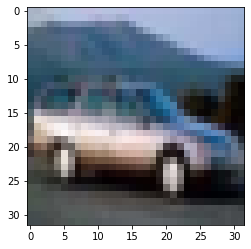

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

digit = train_images[4]
plt.imshow(digit, cmap=plt.cm.binary)

plt.show()

In [4]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32, 32, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [5]:
train_images = train_images[:45000]
train_labels = train_labels[:45000]

valid_images = train_images[-5000:]
valid_labels = train_labels[-5000:]

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(images, labels, sample_count):
    features = np.zeros(shape=(sample_count, 1, 1, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow(
        images, labels,
        batch_size=batch_size)
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_images, train_labels, 45000)
valid_features, valid_labels = extract_features(valid_images, valid_labels, 5000)
test_features, test_labels = extract_features(test_images, test_labels, 10000)

In [8]:
train_features = np.reshape(train_features, (45000, 1 * 1 * 512))
valid_features = np.reshape(valid_features, (5000, 1 * 1 * 512))
test_features = np.reshape(test_features, (10000, 1 * 1 * 512))

In [9]:
  # MAKE WHATEVER CHANGES ARE NECESSARY
  # TO GET 0.7 ACCURACY ON THE TEST SET
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=1 * 1 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 131,585
Trainable params: 131,585
Non-trainable params: 0
_________________________________________________________________


In [11]:
  # MAKE WHATEVER CHANGES ARE NECESSARY
  # TO GET 0.7 ACCURACY ON THE TEST SET

model_hist = model.fit(train_features, train_labels,
          epochs=20, batch_size=20,
            validation_data=(valid_features, valid_labels))
# ADD VALIDATION HERE

Epoch 1/20
2250/2250 [==============================] - 4s 2ms/step - loss: 0.0231 - accuracy: 0.9945 - val_loss: 1.2643e-08 - val_accuracy: 1.0000
Epoch 2/20
2250/2250 [==============================] - 3s 2ms/step - loss: 2.6025e-08 - accuracy: 1.0000 - val_loss: 1.2570e-09 - val_accuracy: 1.0000
Epoch 3/20
2250/2250 [==============================] - 4s 2ms/step - loss: 7.5481e-09 - accuracy: 1.0000 - val_loss: 5.1577e-10 - val_accuracy: 1.0000
Epoch 4/20
2250/2250 [==============================] - 4s 2ms/step - loss: 3.6894e-09 - accuracy: 1.0000 - val_loss: 2.9872e-10 - val_accuracy: 1.0000
Epoch 5/20
2250/2250 [==============================] - 3s 2ms/step - loss: 2.5795e-09 - accuracy: 1.0000 - val_loss: 2.0313e-10 - val_accuracy: 1.0000
Epoch 6/20
2250/2250 [==============================] - 4s 2ms/step - loss: 2.1193e-09 - accuracy: 1.0000 - val_loss: 1.4595e-10 - val_accuracy: 1.0000
Epoch 7/20
2250/2250 [==============================] - 4s 2ms/step - loss: 1.7533e-09 - acc

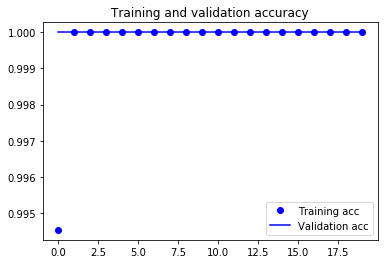

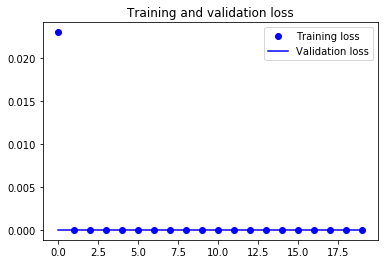

In [12]:
import matplotlib.pyplot as plt

acc = model_hist.history['accuracy']
val_acc = model_hist.history['val_accuracy']
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('test_acc:', test_acc)
test_loss

313/313 [==============================] - 0s 967us/step - loss: 2.5454e-11 - accuracy: 1.0000
test_acc: 1.0


2.545411971477396e-11

In [14]:
model.save_weights('./cifar10_pretrained.h5', overwrite=True)